<a href="https://colab.research.google.com/github/aewallwi/calamity/blob/main/examples/Calibration_Example_Garray_15_Elements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Sep  7 07:06:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install git+https://github.com/aewallwi/calamity.git
!pip install git+https://github.com/HERA-Team/hera_pspec.git

  Cloning https://github.com/aewallwi/calamity.git to /tmp/pip-req-build-yediybhb
  Running command git clone -q https://github.com/aewallwi/calamity.git /tmp/pip-req-build-yediybhb
  Cloning git://github.com/HERA-Team/uvtools to /tmp/pip-install-kypu7f0i/uvtools_32f99aad4081458ab40ffb0dd22782d4
  Running command git clone -q git://github.com/HERA-Team/uvtools /tmp/pip-install-kypu7f0i/uvtools_32f99aad4081458ab40ffb0dd22782d4
     |████████████████████████████████| 62.3 MB 3.0 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached setuptools_scm-6.3.1-py3-none-any.whl (33 kB)
  Created wheel for calamity: filename=calamity-0.0.1-py3-none-any.whl size=732413 sha256=4a5468b705b91b90ebbd10d179950e4f2e03a3f6fecde50bd4881794c9a5c331
  Stored in directory: /tmp/pip-ephem-wheel-cache-26rn371e/wheels/14/57/67/7666166d65813cf0478a60e75899a5e5b68b26b160c0ef8112
  Created wheel for uvtools: filename=uvtool

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from calamity import cal_utils
from calamity import calibration
import numpy as np
from uvtools import dspec
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import copy

In [4]:


def delay_transform_sort_by_baseline_length(uvd, tind=0, polind=0, window='bh', min_bl=0.1, fold=True):
    """
    generate an (NF x NBL) array with baselines arranged in ascending length

    Parameters
    ----------
    uvd: UVData object
        UVData with data that you want to inspect FFT of.
    polind: int, optional
        index of polarization to return.
        default is 0.
    window: str, optional
        fourier transform window function.
        default is blackman harris.
    min_bl: float, optional
        minimum baseline length to include
        default is 0.1 (meters)

    Returns
    -------
    bl_lens: array-like
        Nbls float array with lengths of each baseline.
    delays: array-like
        Nfreqs float array of delays for each baseline.
    fftd_data: array-like
        Nbls x Nfreqs array of data that has been Fourier transformed along the
        frequency axis. Baselines are arranged along baseline axis in ascending length.
    """
    data_inds = np.where(uvd.time_array == np.unique(uvd.time_array)[tind])[0]
    data = uvd.data_array[data_inds, 0, :, polind].reshape(len(data_inds), uvd.Nfreqs)
    bl_lens = np.linalg.norm(uvd.uvw_array[data_inds], axis=1)
    sorted_lens = np.argsort(bl_lens)
    data = data[sorted_lens, :]
    bl_lens = bl_lens[sorted_lens]
    data = data[bl_lens > min_bl]
    bl_lens = bl_lens[bl_lens > min_bl]
    wf = dspec.gen_window(window, uvd.Nfreqs)
    df = np.mean(np.diff(uvd.freq_array))
    delays = 1e9 * np.fft.fftshift(np.fft.fftfreq(uvd.Nfreqs, df))
    fftd_data =  np.fft.fftshift(np.fft.fft(np.fft.fftshift(wf[None, :] * data, axes=1), axis=1), axes=1) * df
    if fold:
      fftd_data = .5 * (fftd_data[:, uvd.Nfreqs//2:] + fftd_data[:, :uvd.Nfreqs//2][:, ::-1])
      delays = delays[uvd.Nfreqs//2:]
    return bl_lens, delays, fftd_data


In [5]:
from calamity.data import DATA_PATH
import glob
import os
from pyuvdata import UVData
uvd_fg = UVData()
uvd_fg.read_uvh5(glob.glob(os.path.join(DATA_PATH, '*nant15*gleam*.uvh5'))[0])
uvd_eor = UVData()
uvd_eor.read_uvh5(glob.glob(os.path.join(DATA_PATH, '*nant15*eor*.uvh5'))[0])
uvd_eor.data_array *= 1
uvd_total = copy.deepcopy(uvd_eor)
uvd_total.data_array += uvd_fg.data_array

In [6]:
# generate uncalibrated data.
uvd_uncalib = copy.deepcopy(uvd_total)
# generate gains
gains = cal_utils.blank_uvcal_from_uvdata(uvd_uncalib)
gains.gain_array = gains.gain_array + 1e-1 * np.random.randn(*gains.gain_array.shape) + 1e-1j * np.random.randn(*gains.gain_array.shape)
# apply gains
uvd_uncalib = cal_utils.apply_gains(uvd_uncalib, gains, inverse=True)

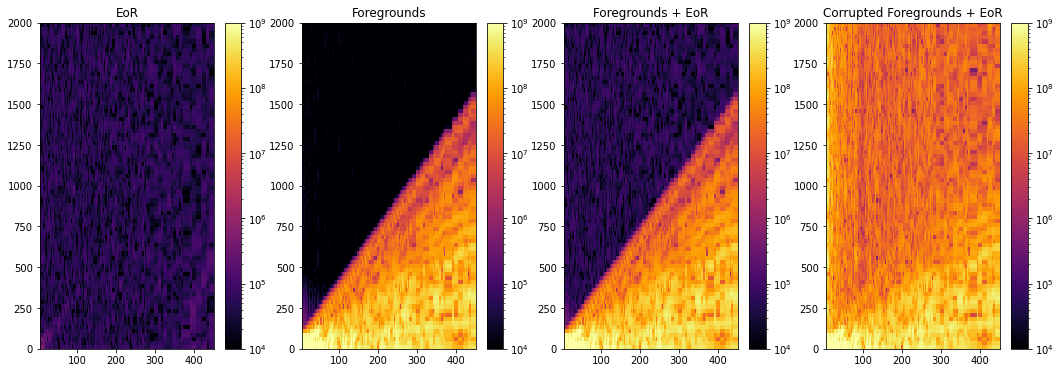

In [7]:
fig, axarr = plt.subplots(1, 4)
fig.set_size_inches(18, 6)
for uvdt, ax, label in zip([uvd_eor, uvd_fg, uvd_total, uvd_uncalib], axarr, ['EoR',  'Foregrounds', 'Foregrounds + EoR', 'Corrupted Foregrounds + EoR']):
  bl, dly, wedge = delay_transform_sort_by_baseline_length(uvdt)
  blg, dlyg = np.meshgrid(bl, dly)
  plt.sca(ax)
  plt.pcolor(blg, dlyg, np.abs(wedge).T, norm=LogNorm(1e4, 1e9), cmap='inferno')
  plt.title(label)
  plt.ylim(0, 2000)
  plt.colorbar()

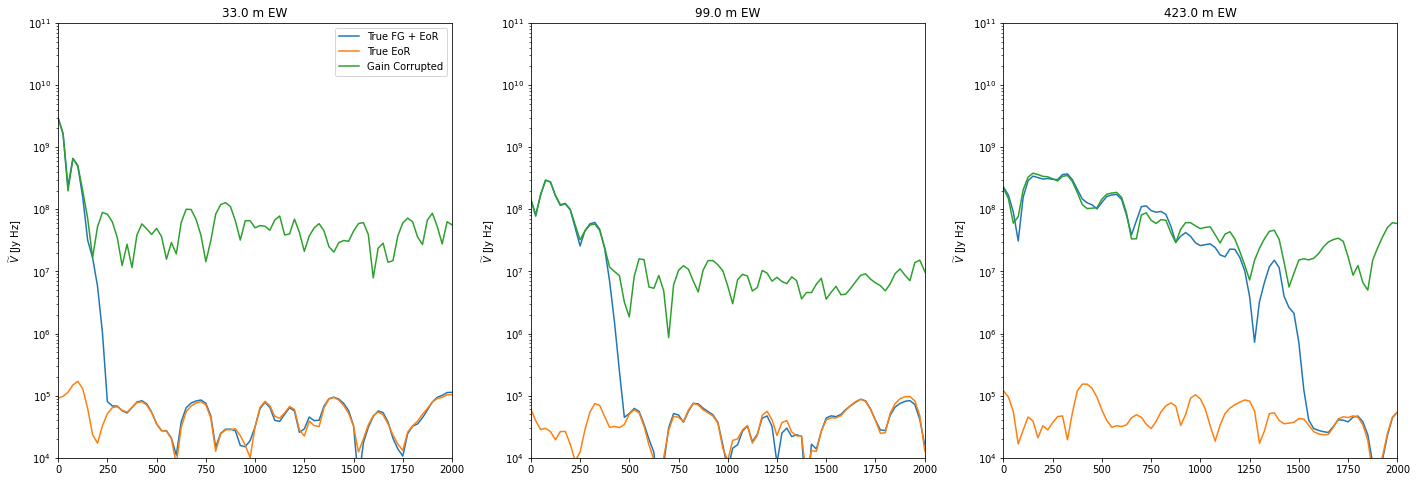

In [8]:
blinds = [10, 30, 100]
fig, axarr = plt.subplots(1, len(blinds))
fig.set_size_inches(24, 8)
labels = ['True FG + EoR', 'True EoR', 'Gain Corrupted']
for blnum, blind in enumerate(blinds):
    plt.sca(axarr[blnum])
    for i, uvt in enumerate([uvd_total,  uvd_eor, uvd_uncalib]):
        x, y, ctot = delay_transform_sort_by_baseline_length(uvt, window='bh7')
        plt.plot(y, np.abs(ctot[blind]), label=labels[i])
        plt.xlim(0, 2000)
        plt.ylim(1e4, 1e11)
        plt.yscale('log')
    plt.title('%.1f m EW'%x[blind])
    if blnum == 0:
      plt.legend()
    plt.ylabel('$\\tau$ [ns]')
    plt.ylabel('$\\widetilde{V}$ [Jy Hz]')

# Calibrate Data.

In [11]:
gains_0 = cal_utils.blank_uvcal_from_uvdata(uvd_uncalib)
model_fit, resid_fit, gains_fit, fitting_info = calibration.calibrate_and_model_dpss(min_dly=2./.3, offset=2./.3, 
                                                                                uvdata=uvd_uncalib, sky_model=uvd_uncalib, freeze_model=False, 
                                                                                gains=gains_0, notebook_progressbar=True, correct_resid=True, correct_model=True,
                                                                                learning_rate=1e-2, verbose=True,
                                                                                use_redundancy=False)

  0%|          | 0/105 [00:00<?, ?it/s]

2021-09-07 07:09:24.003301 Computing foreground components matrices...

2021-09-07 07:09:27.142886Finished Converting Foreground Modeling Components to Tensors...

2021-09-07 07:09:27.143077 Working on pol xx, 1 of 1...

2021-09-07 07:09:27.144689 Working on time 1 of 1...

2021-09-07 07:09:27.144775 Tensorizing data...

2021-09-07 07:09:27.184369 Tensorizing sky model...

2021-09-07 07:09:27.218175 Tensorizing Gains...

2021-09-07 07:09:27.218721 Tensorizing Foreground coeffs...

2021-09-07 07:09:27.218786 Computing initial foreground coefficient guesses using linear-leastsq...



  0%|          | 0/1 [00:00<?, ?it/s]

2021-09-07 07:09:30.391641 Finished initial foreground coefficient guesses...

2021-09-07 07:09:30.391717 Computing initial foreground coefficient guesses using linear-leastsq...



  0%|          | 0/1 [00:00<?, ?it/s]

2021-09-07 07:09:30.749413 Finished initial foreground coefficient guesses...

2021-09-07 07:09:30.757818 Performing gradient descent on 3000 complex gain parameters...
Performing gradient descent on total of 13965 complex foreground parameters
Foreground Parameters grouped into chunks of shape ((nvecs, ngrps): nbls) ['(133, 105):1']
2021-09-07 07:09:30.758127 Building Computational Graph...

2021-09-07 07:09:30.862437 Performing Gradient Descent. Initial MSE of 3.35e-02...



  0%|          | 0/10000 [00:00<?, ?it/s]

2021-09-07 07:11:46.447468 Finished Gradient Descent. MSE of 5.92e-08...



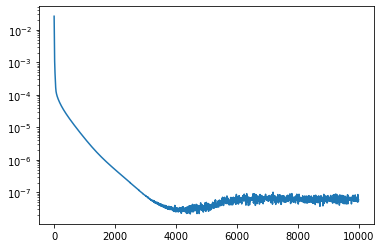

In [12]:
plt.plot(np.abs(fitting_info[0][0]['loss']))
plt.yscale('log')

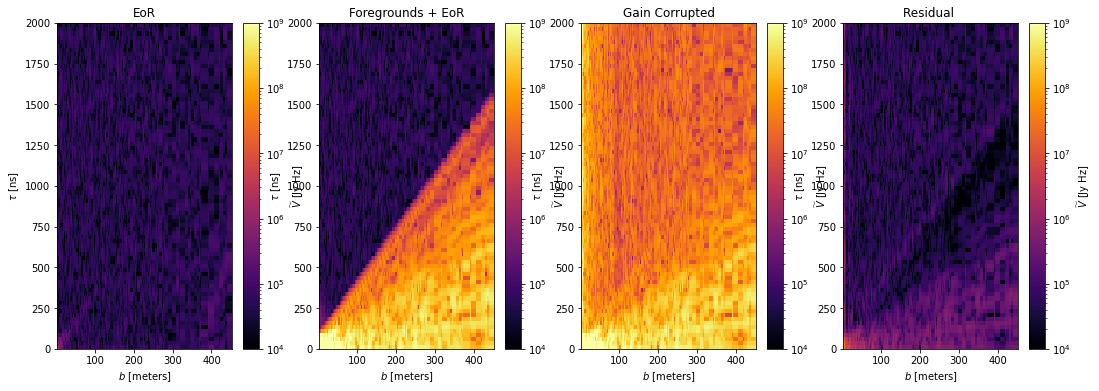

In [13]:
fig, axarr = plt.subplots(1, 4)
fig.set_size_inches(18, 6)
for uvdt, ax, label in zip([uvd_eor, uvd_total, uvd_uncalib, resid_fit], axarr, ['EoR', 'Foregrounds + EoR', 'Gain Corrupted', 'Residual ']):
  bl, dly, wedge = delay_transform_sort_by_baseline_length(uvdt)
  blg, dlyg = np.meshgrid(bl, dly)
  plt.sca(ax)
  plt.pcolor(blg, dlyg, np.abs(wedge).T, norm=LogNorm(1e4, 1e9), cmap='inferno')
  plt.title(label)
  plt.ylim(0, 2000)
  plt.colorbar(label='$\\widetilde{V}$ [Jy Hz]')
  plt.ylabel('$\\tau$ [ns]')
  plt.xlabel('$b$ [meters]')

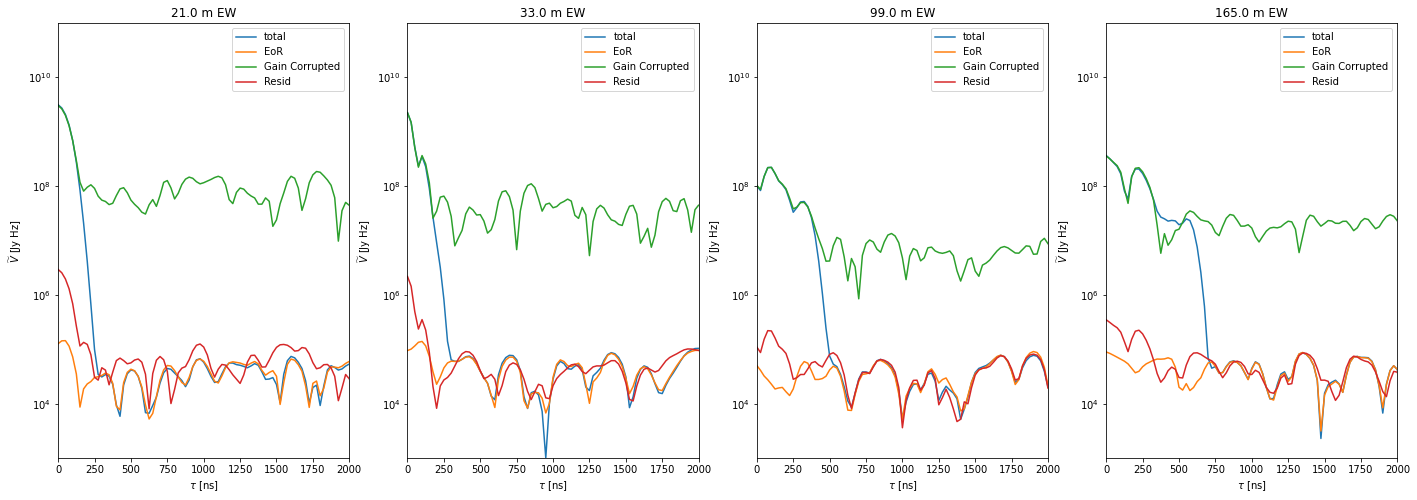

In [14]:
blinds = [6, 10, 30, 50]
fig, axarr = plt.subplots(1, len(blinds))
fig.set_size_inches(24, 8)
for blnum, blind in enumerate(blinds):
    plt.sca(axarr[blnum])
    
    for i, uvt, label in zip(range(4), [uvd_total, uvd_eor,  uvd_uncalib, resid_fit], 
                             ['total', 'EoR', 'Gain Corrupted', 'Resid']):
        x, y, ctot = delay_transform_sort_by_baseline_length(uvt, window='cs11')
        plt.plot(y, np.abs(ctot[blind]), label=label)
        plt.xlim(0, 2000)
        plt.ylim(1e3, 1e11)
        plt.yscale('log')
    plt.title('%.1f m EW'%x[blind])
    plt.legend()
    plt.xlabel('$\\tau$ [ns]')
    plt.ylabel('$\\widetilde{V}$ [Jy Hz]')

# Calculate Power Spectra

In [15]:
from hera_pspec import plot as pspecplot
from hera_pspec import grouping, pspecdata, PSpecBeamGauss, PSpecContainer
# normalization beam for power spectrum
psbeam = PSpecBeamGauss(fwhm=2 * 1.22 * 3e8 / np.mean(resid_fit.freq_array), beam_freqs=resid_fit.freq_array[0])


In [16]:
  psname = 'total_pspec.h5'
  pspecdata.pspec_run(dsets=[uvd_total], filename=psname, taper='bh', 
                      store_window=False, store_cov=False, allow_fft=True, 
                      beam=psbeam, dset_pairs=[(0, 0)], pol_pairs=[('xx', 'xx')], file_type='uvh5',
                      overwrite=True, verbose=False, Jy2mK=True)
  
  psname = 'eor_pspec.h5'
  pspecdata.pspec_run(dsets=[uvd_eor], filename=psname, taper='bh', 
                      store_window=False, store_cov=False, allow_fft=True, 
                      beam=psbeam, dset_pairs=[(0, 0)], pol_pairs=[('xx', 'xx')], file_type='uvh5',
                      overwrite=True, verbose=False, Jy2mK=True)
  
  psname = 'uncalib_pspec.h5'
  pspecdata.pspec_run(dsets=[uvd_uncalib], filename=psname, taper='bh', 
                      store_window=False, store_cov=False, allow_fft=True, 
                      beam=psbeam, dset_pairs=[(0, 0)], pol_pairs=[('xx', 'xx')], file_type='uvh5',
                      overwrite=True, verbose=False, Jy2mK=True)
  
  psname = 'resid_pspec.h5'
  pspecdata.pspec_run(dsets=[resid_fit], filename=psname, taper='bh', 
                      store_window=False, store_cov=False, allow_fft=True, 
                      beam=psbeam, dset_pairs=[(0, 0)], pol_pairs=[('xx', 'xx')], file_type='uvh5',
                      overwrite=True, Jy2mK=True)
psname = 'resid_pspec.h5'
pspecdata.pspec_run(dsets=[resid_fit], filename=psname, taper='bh', 
                    store_window=False, store_cov=False, allow_fft=True, 
                    beam=psbeam, dset_pairs=[(0, 0)], pol_pairs=[('xx', 'xx')], file_type='uvh5',
                    overwrite=True, Jy2mK=True)

Opening resid_pspec.h5 in transactional mode

Setting spectral range: (0, 200)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((12, 13), (12, 13))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((4, 5), (4, 5))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((5, 6), (5, 6))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 1), (0, 1))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((4, 6), (4, 6))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((13, 14), (13, 14))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((12, 

Display Two Dimensional Power Spectra


In [17]:
psc_resid = PSpecContainer('resid_pspec.h5', keep_open=False, mode='rw')
psc_total = PSpecContainer('total_pspec.h5', keep_open=False, mode='rw')
psc_eor = PSpecContainer('eor_pspec.h5', keep_open=False, mode='rw')
psc_uncalib = PSpecContainer('uncalib_pspec.h5', keep_open=False, mode='rw')


uvp_resid = psc_resid.get_pspec('dset0', 'dset0_x_dset0')
uvp_total = psc_total.get_pspec('dset0', 'dset0_x_dset0')
uvp_eor = psc_eor.get_pspec('dset0', 'dset0_x_dset0')
uvp_uncalib = psc_uncalib.get_pspec('dset0', 'dset0_x_dset0')

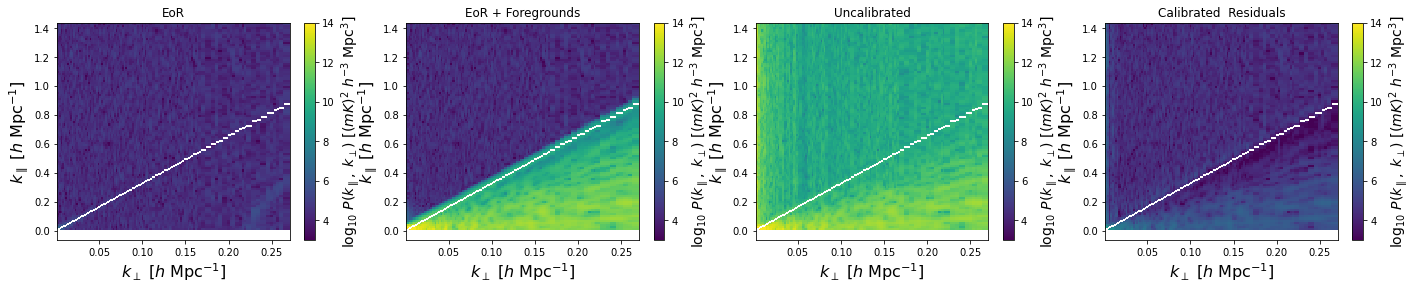

In [18]:
fig, axarr = plt.subplots(1, 4)
fig.set_size_inches(24, 4)
titles = ['EoR', 'EoR + Foregrounds', 'Uncalibrated', 'Calibrated  Residuals']
uvps = [uvp_eor, uvp_total, uvp_uncalib, uvp_resid]
for uvp, ax, title in zip(uvps, axarr, titles):
    plt.sca(ax)
    pspecplot.delay_wedge(uvp, spw=0, pol=('xx', 'xx'), fold=True, rotate=True, delay=False, 
                        ax=ax, vmin=3, vmax=14, colorbar=True, horizon_lines=True, title=title)

# Spherically Average

In [19]:
uniform_stats = {'P_N':{0: np.zeros((uvp_eor.Nblpairts, uvp_eor.Ndlys, uvp_eor.Npols), dtype=complex)}}
uniform_stats['P_N'][0] += (np.mean(np.mean(np.abs(uvp_eor.data_array[0].real) ** 2., axis=1), axis=1)[:, None, None]) ** .5 \
                                + 1j * (np.mean(np.mean(np.abs(uvp_eor.data_array[0].imag) ** 2., axis=1), axis=1)[:, None, None]) ** .5

pspec_sph = {}

kparas = uvp_eor.get_kparas(0)
nk = len(kparas)
kbins = kparas[nk // 2:][::4]
dk = np.mean(np.diff(kbins))
kwidths = np.ones_like(kbins) * dk

for uvp, title in zip(uvps, titles):
  uvp.stats_array = copy.deepcopy(uniform_stats)
  uvp.set_stats_slice('P_N', m=1/0.299, b=100., above=False, val=1e40)
  pspec_sph[title] = grouping.spherical_average(uvp, kbins=kbins, bin_widths=kwidths, error_weights='P_N')

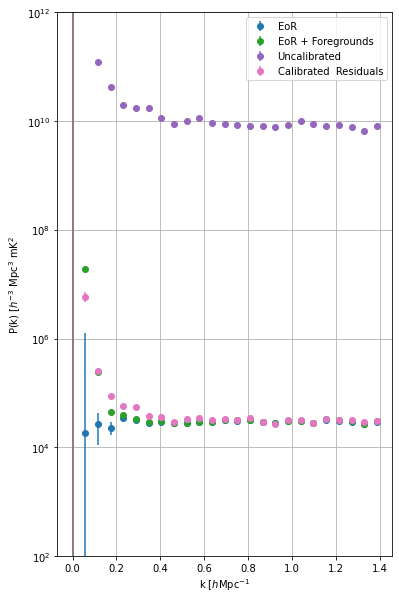

In [20]:
fig = plt.figure(figsize=(6, 10))
for title in pspec_sph:
  blpair = pspec_sph[title].get_blpairs()[0]
  k = (0, blpair, ('xx', 'xx'))
  data = pspec_sph[title].get_data(k).real.squeeze()
  errs = pspec_sph[title].get_stats('P_N', k).real.squeeze()
  gtz = data >= 0.
  ltz = data <= 0.
  plt.errorbar(kbins[gtz], np.abs(data[gtz]), errs[gtz], label=title, marker='o', ls='none')
  plt.errorbar(kbins[ltz], np.abs(data[ltz]), errs[ltz], marker='o', ls='none', markerfacecolor='none')
plt.yscale('log')
plt.ylim(1e2, 1e12)
plt.legend()
plt.xlabel('k [$h$Mpc$^{-1}$')
plt.ylabel('P(k) [$h^{-3}$ Mpc$^3$ mK$^2$')
plt.grid()